# Assignment 7: Transfer Learning


The goal of this exercise is to learn how to use pre-trained networks in transfer learning tasks.
We will make use of networks trained on ImageNet, and apply them to related problems, i.e., the classification of $6$ categories such as buildings, forests, glaciers, mountains, seas, and streets.

## Dataset

For this exercise we use the  [Intel Image Classification](https://www.kaggle.com/datasets/puneet6060/intel-image-classification) dataset that can be downloaded from the official website [here]({https://www.kaggle.com/datasets/puneet6060/intel-image-classification}).
The dataset contains $25000$ color images of pixels size $150\times 150$ in $6$ classes: buildings, forests, glaciers, mountains, seas, and streets. We will be using only $17000$ of those images where $14000$ are for training and $3000$ for test.

### Test 0: Download and check if dataset is downloaded correctly

#### Download the dataset by running the code below

In [ ]:
#Library for downloading datasets from Kaggle
! pip install opendatasets --upgrade --quiet

In [ ]:
import json

# Write kaggle.json file
with open('kaggle.json', 'w') as file:
    json.dump({'username': '', 'key': ''}, file)

import opendatasets
opendatasets.download('https://www.kaggle.com/puneet6060/intel-image-classification')

100%|██████████| 346M/346M [00:03<00:00, 110MB/s] 


After running the cell above, just verify that the dataset has been downloaded correctly by running the cell below.

In [ ]:
import os

def count_images(directory):
    """Count the number of image files in the given directory and its subdirectories."""
    count = 0
    for root, dirs, files in os.walk(directory):
        count += sum(1 for file in files if file.endswith(('.jpg', '.jpeg', '.png')))
    return count

def validate_dataset(base_path):
    """Validate the structure and the count of images in the dataset."""
    expected_structure = {
        'seg_train': 14034,
        'seg_test': 3000
    }

    errors = []

    # Check if base directory exists
    if not os.path.exists(base_path):
        errors.append(f"Base directory {base_path} does not exist.")
        return errors

    # Check each subdirectory and count images
    for folder, expected_count in expected_structure.items():
        folder_path = os.path.join(base_path, folder)
        if not os.path.exists(folder_path):
            errors.append(f"Expected folder {folder_path} does not exist.")
        else:
            image_count = count_images(folder_path)
            if image_count != expected_count:
                errors.append(f"Folder {folder} has {image_count} images, expected {expected_count}.")

    return errors

# Specify the path to the base of the dataset
base_dataset_path = "intel-image-classification/" #Change if you downloaded manually to some other path

# Perform the validation
validation_errors = validate_dataset(base_dataset_path)

if not validation_errors:
    print("Dataset is validated successfully. Test Passed")
else:
    print("Errors found in dataset validation:")
    for error in validation_errors:
        print(error)

Dataset is validated successfully. Test Passed


### Task 1: Data Transformation

We need to instantiate a proper `torchvision.transform` instance to create the same input structure as used for training our network.
We need to combine 4 transforms. The different transforms in Pytorch are available here: https://pytorch.org/vision/0.9/transforms.html.

1. We need to resize the image such that the shorter side has size 256.
2. We need to take the center crop of size $224\times224$ from the image.
3. We need to convert the image into a tensor (including pixel values scaling)
4. We need to normalize the pixel values with mean $(0.485, 0.456, 0.406)$ and standard deviation $(0.229, 0.224, 0.225)$.

Since we will use networks pre-trained on ImageNet, we need to perform the exact same transform as used for ImageNet testing.

In [ ]:
import torch
import torchvision

imagenet_transform = torchvision.transforms.Compose([
  torchvision.transforms.Resize(256),
  torchvision.transforms.CenterCrop(224),
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
])

# flag used for moving data to GPU if available
cuda_available = True
if torch.cuda.is_available():
  print("Successfully enabled CUDA processing")
else:
  cuda_available = False
  print("CUDA processing not available. Things will be slow :-(")

Successfully enabled CUDA processing


### Task 2: Dataset Loading

We here use the [ImageFolder](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html) class from pytorch to load our training and test set respectively.

This task consists of two parts:

1. Create two datasets, one for the training set, one for the test set. Use the transform defined above.
2. Once the datasets are created, create two data loaders, one for training set, one for test set. Use a proper value of the batch-size $B = 256$. Make sure the trainloader shuffle is set to True.

In [ ]:
from torchvision.datasets import ImageFolder

#Path to your training and test data (If different, change the path accordingly)
train_dir = './intel-image-classification/seg_train/seg_train/'
test_dir = './intel-image-classification/seg_test/seg_test/'

trainset = ImageFolder(root=train_dir, transform=imagenet_transform)
testset = ImageFolder(root=test_dir, transform=imagenet_transform)

In [ ]:
B = 32
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True,batch_size=B)
testloader = torch.utils.data.DataLoader(testset, shuffle=False, batch_size=B)

### Test 1: Data Size and Types

We check that all input images are `torch.tensors` of size $3\times224\times224$ and of type `torch.float` and that all labels are of type `int`.

Note: the sanity check is only performed on the test set.

In [ ]:
for x, t in testset:
  assert isinstance(x, torch.Tensor)
  assert isinstance(t, int)
  assert x.shape==(3,224,224)
  assert x.dtype==torch.float
  assert x.max() < 3.0
  assert x.min() > -3.0

## Deep Feature Extraction

We will use a pre-trained network available in `PyTorch`.
Particularly, we will use a ResNet-50 architecture, but other architectures can also be tested.
Fortunately, PyTorch provides simple interfaces to obtain pre-trained models, e.g., using the `torchvision.models.resnet50` interface function.

In order to use the networks in a different dataset, we need to change their outputs.
There are several possibilities on how to achieve that, and you have the freedom to choose.

For your reference, the implementation of the `forward` function of ResNet networks (including ResNet-50) can be found here: https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L266

You can also check if other networks perform better, for example, deeper ResNet topologies.
Be aware that the strategy to replace the last fully-connected layer might not work the same way in other network topologies, only in residual networks.

### Task 3: Pre-trained Network Instantiation

Instantiate two pre-trained networks of type ResNet-50.

1. Freeze the feature layers of the first network.

Note: Make use the `old TorchVision Interface` to load your pre-trained network. Here is the link: https://pytorch.org/vision/0.12/models.html

In [ ]:
# instantiate the first pre-trained resnet 50 network
network_1 = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
# Make sure to freeze all the layers of the network.
for param in network_1.parameters():
  param.requires_grad = False

# instantiate the second pre-trained resnet 50 network without the freezing
network_2 = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 106MB/s]


### Task 4: Network Implementation

We want to modify the network such that we extract the logits for the 6 classes from the last fully-connected layer of the network.

Implement a function that:
1. Replaces the current last linear layer of the pre-trained network with a new linear layer that has $O$ units ($O$ represents the number of classes in our dataset).

In [ ]:
def replace_last_layer(network, O=6):
  # replace the last linear layer with the new layer
  in_features = network.fc.in_features
  new_fc = torch.nn.Linear(in_features, O)
  network.fc = new_fc

  return network

### Test 2: Last layer dimensions

This test ensures that the function return a network having the correct number of input and output units in the last layer.

In [ ]:
O = 6
for network in (network_1, network_2):
  new_model = replace_last_layer(network, O=O)
  assert new_model.fc.out_features == O
  assert new_model.fc.in_features == 2048

## Network Training
Implement a function that takes all necessary parameters to run a training on a given dataset.
Select the optimizer to be `torch.optim.SGD` and `torch.nn.CrossEntropyLoss` as the loss function.
The test set will be used as the validation set.

### Task 5: Training and Evaluation Loop

Implement a training loop over a specific number of epochs (5) with a learning rate of $\eta=0.001$ and momentum of $\mu = 0.9$. The function should return the predictions and the labels on the validation set after 5 epochs.

- In each loop, compute and print the training loss, training accuracy, validation loss and validation accuracy.

- Make sure that you train on the training data only, and `not` on the validation data.

- During training, make sure your model is in training mode - `model.train()` while during test it is in eval mode - `model.eval()`

- Moreover, during eval mode - please use `with torch.no_grad():` and loop on testloader inside it. This disables gradient computation and therefore saves memory.

- While saving your pred and target, please use `.detach().cpu().numpy()` before appending your predictions and targets to your list that you will return at the end of your function.

In [ ]:
from tqdm.notebook import tqdm  # used for progress bar visualization
import numpy

def train_eval(model, dataloaders, epochs=1000, eta=0.01, momentum=0):
  trainloader, testloader = dataloaders
  # select loss function and optimizer
  optimizer = torch.optim.SGD(
    params=model.parameters(),
    lr=eta,
    momentum=momentum
  )
  loss = torch.nn.CrossEntropyLoss()

  if cuda_available:
    # instantiate the correct device
    device = torch.device("cuda")
    model = model.to(device)

  # collect loss values and accuracies over the training epochs
  train_loss, train_acc, val_loss, val_acc, curr_pred, curr_target = [], [], [], [], [], []

  # training process
  for epoch in tqdm(range(epochs), desc='epoch'):
    # set your model to model.train()
    model.train()
    train_loss_epoch = 0
    train_number_correct_pred = 0
    # train network on training data
    for x, t in tqdm(trainloader, desc='training', colour='purple', leave=False):
      optimizer.zero_grad()
      if cuda_available:
        # put data to device
        x, t = x.to(device), t.to(device)
      # train
      z = model(x)
      J = loss(z, t)
      J.backward()
      optimizer.step()
      train_loss_epoch += J.item()
      # compute training accuracy
      train_number_correct_pred += (torch.argmax(z, dim=1) == t).sum().item()

    # calculate training accuracies and losses for current epoch
    train_loss.append(train_loss_epoch / trainloader.batch_size)
    train_acc.append(train_number_correct_pred / len(trainloader.dataset))

    # testing process
    # set your model to model.eval(). Use with torch.no_grad() and loop inside it for testloader
    model.eval()
    with torch.no_grad():
      val_loss_epoch = 0
      val_number_correct_pred = 0
      for x_val, t_val in tqdm(testloader, desc='testing', colour='orange', leave=False):
        if cuda_available:
          # put data to device
          x_val, t_val = x_val.to(device), t_val.to(device)
        # compute validation loss
        z_val = model(x_val)
        J_val = loss(z_val, t_val)
        val_loss_epoch += J_val.item()
        # compute validation accuracy
        val_number_correct_pred += (torch.argmax(z_val, dim=1) == t_val).sum().item()

        # save predictions and targets during last epoch
        if epoch == epochs - 1:
          if cuda_available:
            curr_pred.append(z_val.detach().cpu().numpy())
            curr_target.append(t_val.detach().cpu().numpy())
          else:
            curr_pred.append(z_val)
            curr_target.append(t_val)

      # calculate validation accuracies and losses for current epoch
      val_loss.append(val_loss_epoch / testloader.batch_size)
      val_acc.append(val_number_correct_pred / len(testloader.dataset))

    # print accuracies and losses for current epoch
    print(f"Epoch {epoch + 1}/{epochs}:")
    print(f"  Training Loss: {train_loss[-1]:.4f}")
    print(f"  Training Accuracy: {train_acc[-1]:.4f}")
    print(f"  Validation Loss: {val_loss[-1]:.4f}")
    print(f"  Validation Accuracy: {val_acc[-1]:.4f}")

  pred, target = numpy.concatenate(curr_pred), numpy.concatenate(curr_target)

  return pred, target

### Task 6: Network Fine-Tuning with Frozen Layers

Create a network that has feature layers frozen with $6$ output units.
Fine-tune the created network on our Intel Image Classification data using the previous function.

In [ ]:
network_with_frozen_layers = replace_last_layer(network_1, O=6)
pred_frozen, targ_frozen = train_eval(network_with_frozen_layers, (trainloader, testloader), epochs=5, eta=0.001, momentum=0.9)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/439 [00:00<?, ?it/s]

testing:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 1/5:
  Training Loss: 10.7191
  Training Accuracy: 0.8158
  Validation Loss: 1.4297
  Validation Accuracy: 0.8767


training:   0%|          | 0/439 [00:00<?, ?it/s]

testing:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 2/5:
  Training Loss: 6.0287
  Training Accuracy: 0.8784
  Validation Loss: 1.1268
  Validation Accuracy: 0.8857


training:   0%|          | 0/439 [00:00<?, ?it/s]

testing:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 3/5:
  Training Loss: 5.1511
  Training Accuracy: 0.8903
  Validation Loss: 1.0294
  Validation Accuracy: 0.8933


training:   0%|          | 0/439 [00:00<?, ?it/s]

testing:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 4/5:
  Training Loss: 4.7114
  Training Accuracy: 0.8952
  Validation Loss: 0.9525
  Validation Accuracy: 0.8977


training:   0%|          | 0/439 [00:00<?, ?it/s]

testing:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 5/5:
  Training Loss: 4.4953
  Training Accuracy: 0.8975
  Validation Loss: 0.9208
  Validation Accuracy: 0.8970


### Task 7: Network Fine-Tuning without Frozen Layers

Create a network from the second pre-trained network with $6$ output units. This network should not have the layers frozen.
Fine-tune the created network on our dataset.

Note:

  * The fine-tuning of the network can take a long time (> 30 minutes) when the layers are not frozen.

In [ ]:
network_normal = replace_last_layer(network_2, O=6) # Use network_2 defined above and replace the last layer
pred_unfrozen, targ_unfrozen = train_eval(network_normal, (trainloader, testloader), epochs=5, eta=0.001, momentum=0.9)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/439 [00:00<?, ?it/s]

testing:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 1/5:
  Training Loss: 7.2363
  Training Accuracy: 0.8497
  Validation Loss: 0.7108
  Validation Accuracy: 0.9147


training:   0%|          | 0/439 [00:00<?, ?it/s]

testing:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 2/5:
  Training Loss: 3.0723
  Training Accuracy: 0.9228
  Validation Loss: 0.6028
  Validation Accuracy: 0.9273


training:   0%|          | 0/439 [00:00<?, ?it/s]

testing:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 3/5:
  Training Loss: 2.3774
  Training Accuracy: 0.9403
  Validation Loss: 0.5760
  Validation Accuracy: 0.9297


training:   0%|          | 0/439 [00:00<?, ?it/s]

testing:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 4/5:
  Training Loss: 1.8447
  Training Accuracy: 0.9543
  Validation Loss: 0.5501
  Validation Accuracy: 0.9317


training:   0%|          | 0/439 [00:00<?, ?it/s]

testing:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 5/5:
  Training Loss: 1.4062
  Training Accuracy: 0.9673
  Validation Loss: 0.5657
  Validation Accuracy: 0.9320


## Plotting

Finally, we want to plot the confusion matrix of the test set.
For this, we need use the predictions and target values we saved from the previous tasks (Task 6 and Task 7).
Finally, we can make use of the `sklearn.metrics.confusion_matrix` to compute the confusion matrix.
You can utilize `sklearn.metrics.ConfusionMatrixDisplay` for displaying the confusion matrix, or `pyplot.imshow` and adding the according labels.

Note:

  * The documentation for the confusion matrix can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
  * The interface and an example for the `ConfusionMatrixDisplay` can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

### Task 8: Confusion Matrix Plotting

* Plot the confusion matrix for the fine-tuned network with frozen layers.
* Also plot the confusion matrix for the second fine-tuned network without frozen layers.
* Compare the two

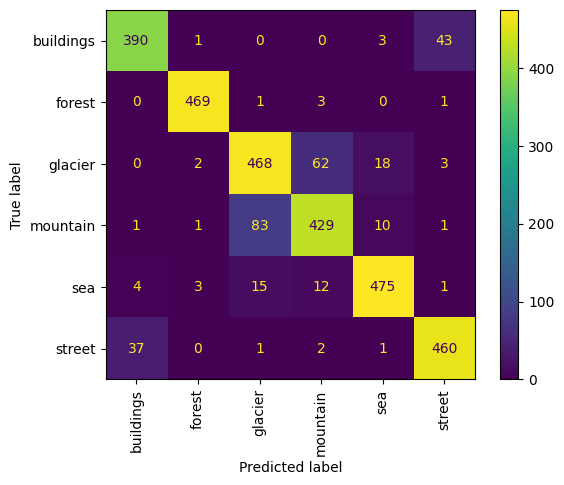

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# add axis labels if required
classes = trainset.classes

# compute confusion matrix
matrix_frozen = confusion_matrix(targ_frozen, numpy.argmax(pred_frozen, axis=1)) # Use predictions and target from the fine-tuned network with frozen layers
matrix_unfrozen = confusion_matrix(targ_unfrozen, numpy.argmax(pred_unfrozen, axis=1)) # Use predictions and target from the fine-tuned network without frozen layers

# plot confusion matrices
plot_conf_matrix1 = ConfusionMatrixDisplay(matrix_frozen, display_labels=classes)
plot_conf_matrix1.plot(xticks_rotation = "vertical")
plt.show()

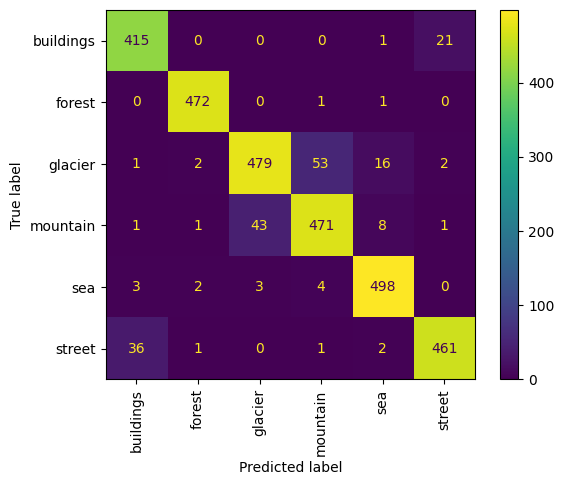

In [ ]:
plot_conf_matrix2 = ConfusionMatrixDisplay(matrix_unfrozen, display_labels=classes)
plot_conf_matrix2.plot(xticks_rotation = "vertical")
plt.show()

##Comparison
As both of the models already have been pre-trained, there is little difference in performance of the models. The model with the unfrozen layers, however, does performs better than the frozen one. Most of the classes are classified very accurately but both models struggle a bit with the classification of mountains and glaciers as well as buildings and streets. This is also explainable as glaciers are mostly surrounded by mountains such that both classes might be present in the image. The same goes for the two classes building and street, but there the confusion is a bit smaller.